# Representation Learning using Auto Encoders

In [3]:
import keras as K
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from keras.datasets import mnist
from sklearn.model_selection import train_test_split

2024-05-12 13:58:50.507942: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-12 13:58:50.508085: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-12 13:58:50.621941: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
print("Keras version:", K.__version__)
print("TensorFlow version:", tf.__version__)

Keras version: 3.2.1
TensorFlow version: 2.15.0


In [5]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
if tf.config.experimental.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")

Num GPUs Available:  2
GPU is available


In [6]:
data = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [7]:
(X_train, y_train), (X_test, y_test) = data
X_train.shape, X_test.shape

((60000, 28, 28), (10000, 28, 28))

In [8]:
X_train = X_train / 255
X_test = X_test / 255

In [9]:
def noising_process(input, stddev=0.1):

    noised_input = input + np.random.normal(0, stddev, input.shape)
    return np.clip(noised_input, 0.0, 1.0)

def print_imgs(real, reconstructed, num_images=10, pure_noise=False, model=None):

    if pure_noise:
        reconstructed = []
        if model is None:
            print("Model must be passed")
            return
        
    indices = np.random.choice(len(real), size=num_images, replace=False)

    fig, axes = plt.subplots(2, num_images, figsize=(20, 4))
    axes[0, 0].set_title('Original Images', fontsize=12)
    axes[1, 0].set_title('Reconstructed Images', fontsize=12)
    
    for idx, index in enumerate(indices):
        ax1 = axes[0, idx]
        ax1.imshow(real[index].reshape(28, 28), cmap='gray')
        ax1.axis('off')

        if pure_noise:
            recon_img = convergence_to_manifold(model, real[index], verbose=0)
            reconstructed.append(recon_img)

        ax2 = axes[1, idx]
        if pure_noise:
            ax2.imshow(tf.reshape(reconstructed[idx], (28, 28)), cmap='gray')
        else:
            ax2.imshow(reconstructed[index].reshape(28, 28), cmap='gray')
        ax2.axis('off')

    plt.tight_layout()
    plt.show()

def convergence_to_manifold(model, target_image, max_iter=1000, eps=1e-5, verbose=2):

    previous_loss = None

    target = tf.convert_to_tensor(target_image, dtype=np.float32)
    noised_image = tf.Variable(initial_value=tf.reshape(np.random.normal(0, 1, (28, 28)).astype(np.float32), shape=(1, 28, 28)), trainable=True)
    optimizer = tf.optimizers.Adam(learning_rate=0.01)

    for iteration in range(max_iter):

        with tf.GradientTape() as g:
            g.watch(noised_image)
            reconstruction = model(noised_image)
            loss = tf.reduce_sum(tf.square(reconstruction - target))  # to maximize similarity through MSE

        # Compute gradients and apply them through the optimizer
        gradients = g.gradient(loss, [noised_image])
        optimizer.apply_gradients(zip(gradients, [noised_image]))

        current_loss = loss.numpy()

        if iteration % 1000 == 0 and verbose > 1:
            print(f'iteration: {iteration}, loss: {current_loss}')

        if previous_loss is not None and abs(previous_loss - current_loss) < eps and verbose > 1:
            print(f"Converged at iteration {iteration} w/ loss: {current_loss} and epsilon: {previous_loss - current_loss}")
            break
        
        if iteration == max_iter - 1 and verbose> 0:
            print(f"Not converged. Last iteration {iteration} w/ loss: {current_loss} and epsilon: {previous_loss - current_loss}")

        previous_loss = current_loss
        
    return reconstruction

In [11]:
inputs = K.Input((28, 28))
x = K.layers.Flatten()(inputs)
x = K.layers.Dense(1024, activation='relu')(x)
x = K.layers.Dense(784, activation='sigmoid')(x)
outputs = K.layers.Reshape((28, 28)) (x)
model = K.Model(inputs=inputs, outputs=outputs)

model.summary()

model.compile(
    optimizer='adam',
    loss='mean_squared_error'
)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 28, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │       803,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 784)            │       803,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 28, 28)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,607,440 (6.13 MB)

 Trainable params: 1,607,440 (6.13 MB)

 Non-trainable params: 0 (0.00 B)

Let's first see if the model is good enough to learn the identity function:

In [12]:
model.fit(
    X_train,
    X_train,
    epochs=20,
    batch_size=128,
    shuffle=True,
    validation_data=(X_test, X_test)
)

Epoch 1/20
 76/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0882

I0000 00:00:1715522372.039283     116 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1715522372.053894     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0393

W0000 00:00:1715522373.769845     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715522374.336624     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.0392 - val_loss: 0.0069
Epoch 2/20
 80/469 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0069

W0000 00:00:1715522374.735194     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0061 - val_loss: 0.0040
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0039 - val_loss: 0.0030
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0029 - val_loss: 0.0025
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0025 - val_loss: 0.0021
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0020 - val_loss: 0.0016
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 9/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 10/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 11/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 12/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0010 - val_loss: 0.0010
Epoch 13/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 9

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


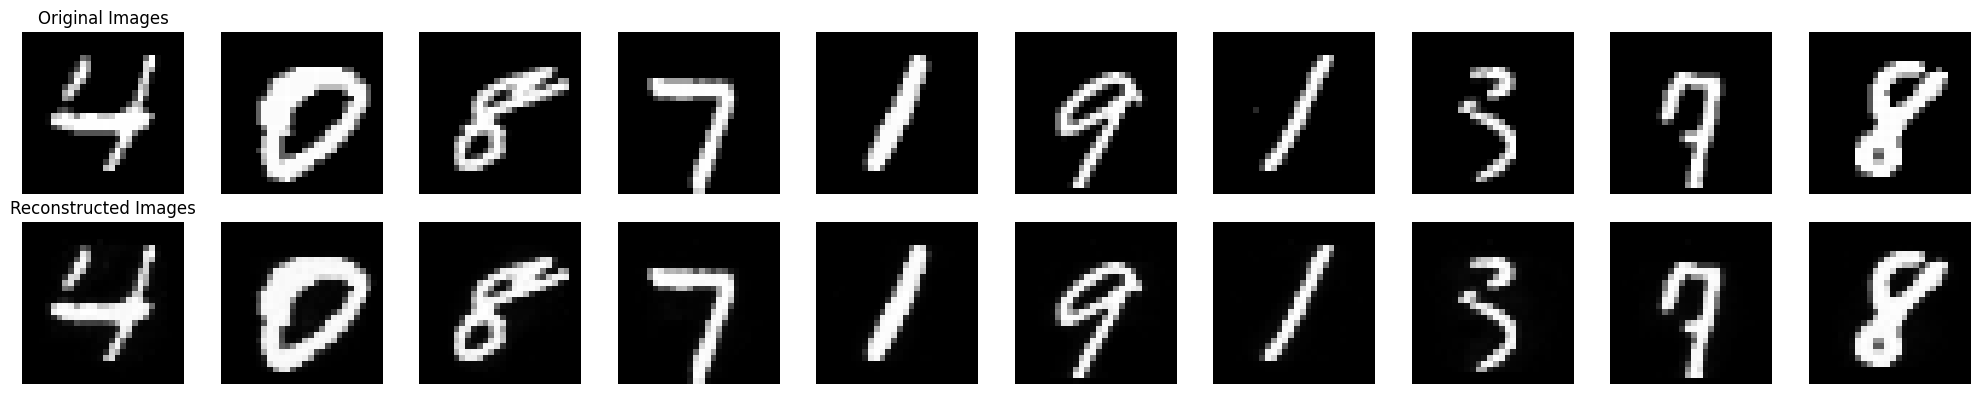

In [13]:
predictions = model.predict(X_test)
print_imgs(X_test, predictions)

Now let's see if it learns the distributiono using the noised version of the input (we'll start by a small gaussian noise, i.e. one with stddev=0.1):

In [14]:
model.fit(
    noising_process(X_train, 0.1),
    X_train,
    epochs=20,
    batch_size=128,
    shuffle=True,
    validation_data=(noising_process(X_test, 0.1), X_test),
)

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0022 - val_loss: 0.0016
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0014 - val_loss: 0.0016
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 9/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 10/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 11/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 12/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


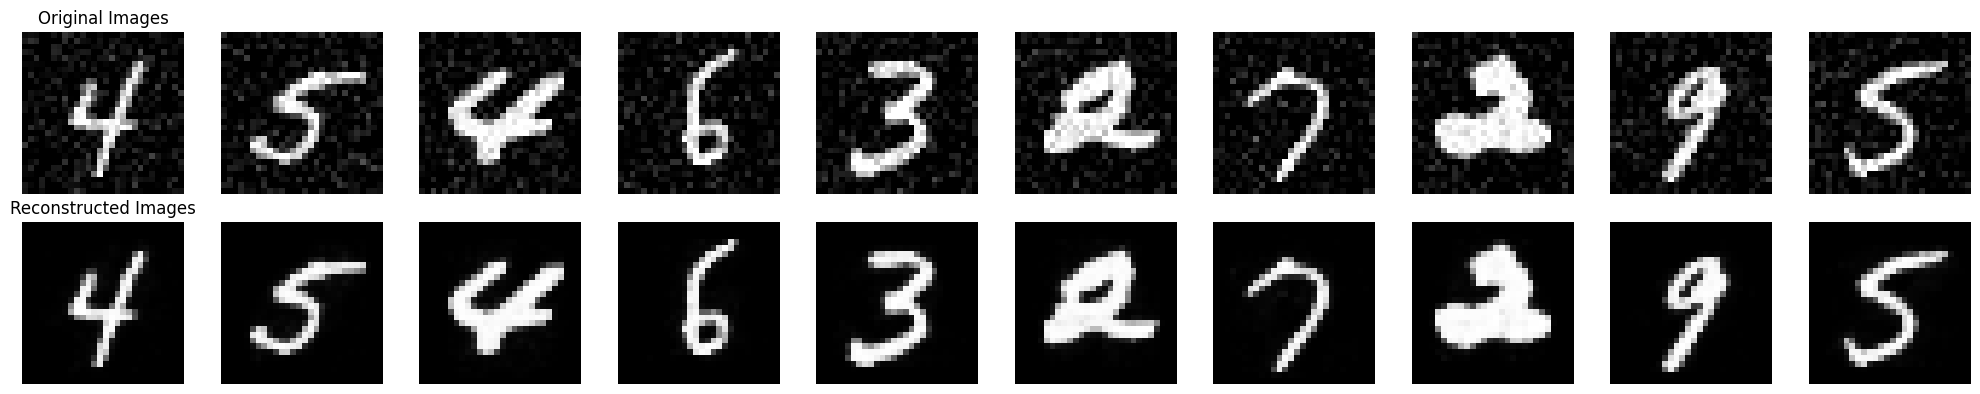

In [15]:
noised_data = noising_process(X_test, 0.1)

predictions = model.predict(noised_data)
print_imgs(noised_data, predictions)

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


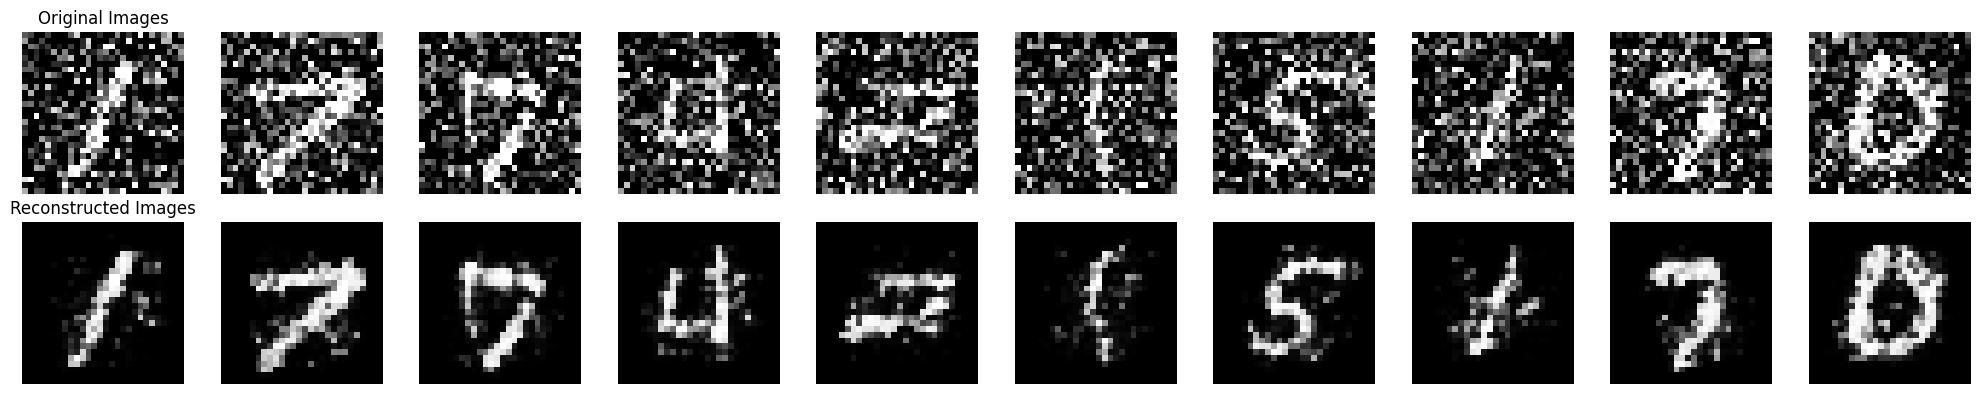

In [16]:
noised_data = noising_process(X_test, 0.5)

predictions = model.predict(noised_data)
print_imgs(noised_data, predictions)

Since the model struggles a bit to reconstruct images with stronger noise, we will retrain it using more disturbed images

In [17]:
inputs = K.Input((28, 28))
x = K.layers.Flatten()(inputs)
x = K.layers.Dense(1024, activation='relu')(x)
x = K.layers.Dense(784, activation='sigmoid')(x)
outputs = K.layers.Reshape((28, 28)) (x)
model = K.Model(inputs=inputs, outputs=outputs)

model.summary()

model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mean_squared_error', 'binary_crossentropy']
)

early_stopping = K.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=5,
    verbose=1,
    restore_best_weights=True)

model.fit(
    noising_process(X_train, 0.5),
    X_train,
    epochs=20,
    batch_size=128,
    shuffle=True,
    validation_data=(noising_process(X_test, 0.5), X_test),
    callbacks=[early_stopping]
)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 28, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │       803,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 784)            │       803,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 28, 28)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,607,440 (6.13 MB)

 Trainable params: 1,607,440 (6.13 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
 39/469 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - binary_crossentropy: 0.4344 - loss: 0.1075 - mean_squared_error: 0.1075

W0000 00:00:1715522435.166341     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - binary_crossentropy: 0.3221 - loss: 0.0502 - mean_squared_error: 0.0502

W0000 00:00:1715522437.134853     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715522437.856579     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - binary_crossentropy: 0.3220 - loss: 0.0501 - mean_squared_error: 0.0501 - val_binary_crossentropy: 0.1430 - val_loss: 0.0191 - val_mean_squared_error: 0.0191
Epoch 2/20
 34/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_crossentropy: 0.1437 - loss: 0.0191 - mean_squared_error: 0.0191

W0000 00:00:1715522438.253661     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - binary_crossentropy: 0.1309 - loss: 0.0178 - mean_squared_error: 0.0178 - val_binary_crossentropy: 0.1146 - val_loss: 0.0154 - val_mean_squared_error: 0.0154
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_crossentropy: 0.1124 - loss: 0.0149 - mean_squared_error: 0.0149 - val_binary_crossentropy: 0.1096 - val_loss: 0.0143 - val_mean_squared_error: 0.0143
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_crossentropy: 0.1080 - loss: 0.0137 - mean_squared_error: 0.0137 - val_binary_crossentropy: 0.1075 - val_loss: 0.0137 - val_mean_squared_error: 0.0137
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_crossentropy: 0.1052 - loss: 0.0129 - mean_squared_error: 0.0129 - val_binary_crossentropy: 0.1060 - val_loss: 0.0134 - val_mean_squared_error: 0.0134
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - binary_crossentropy: 0.1031 - loss: 0.0123 - mean_squared_error: 0.0123 - val_binary_crossentropy: 0.1047 - v

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


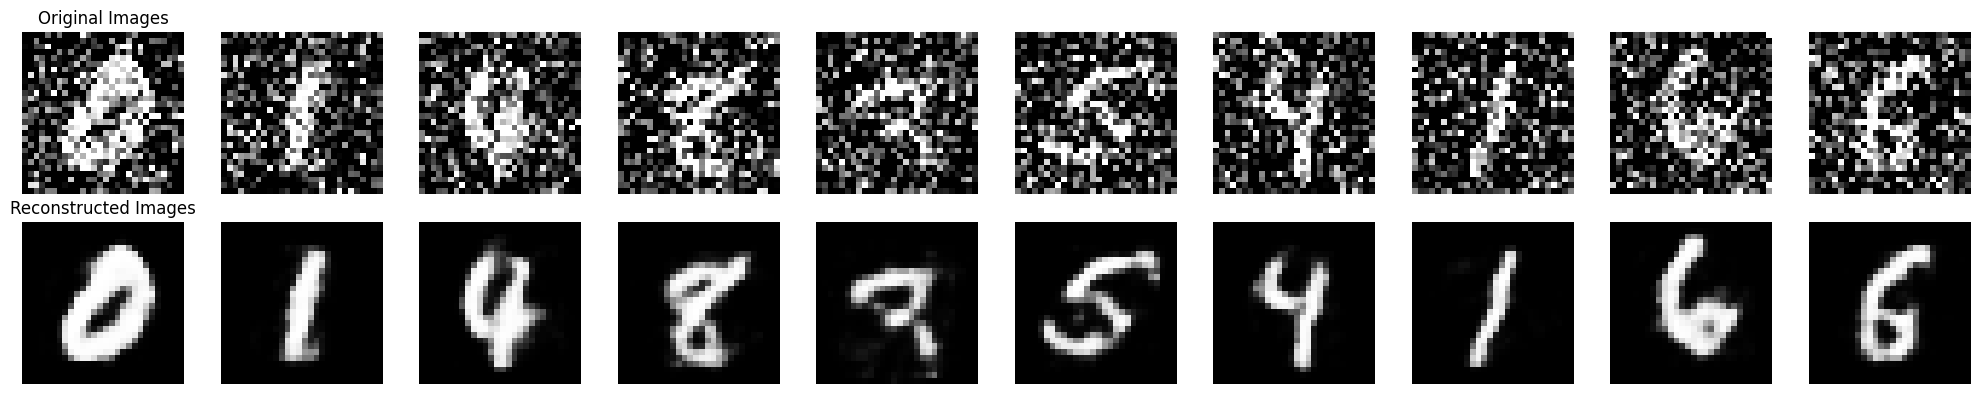

In [18]:
noised_data = noising_process(X_test, 0.5)

predictions = model.predict(noised_data)
print_imgs(noised_data, predictions)

In [19]:
noisy_test = noising_process(X_test, 0.5)
predictions = model.predict(noisy_test)
mse = K.losses.MeanSquaredError()
reconstruction_error = mse(X_test, predictions).numpy()

print(f'Reconstruction error: {reconstruction_error}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Reconstruction error: 0.012524875812232494


and as we can see, the model actually does a better job at reconstructing strong-noised images (in this case gaussian noise with 0.5 stddev)

Now we will observe what happens if we follow the gradient of the probability function

First, we will look at what happens when starting from a real image to which we add some noise (following the gradient must result in a very precise result of the digit)

In [21]:
reconstruction = convergence_to_manifold(model, X_test[0])

iteration: 0, loss: 55.2286376953125
Not converged. Last iteration 999 w/ loss: 0.05607391148805618 and epsilon: 3.094598650932312e-05


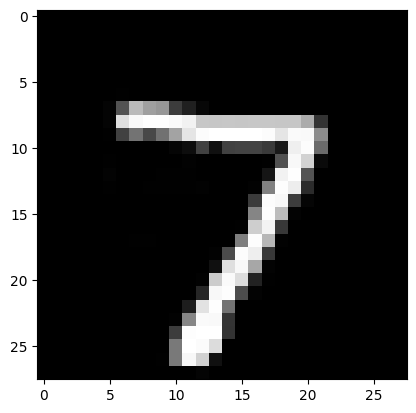

In [22]:
plt.imshow(tf.reshape(reconstruction, (28, 28)), cmap='gray')
plt.show()

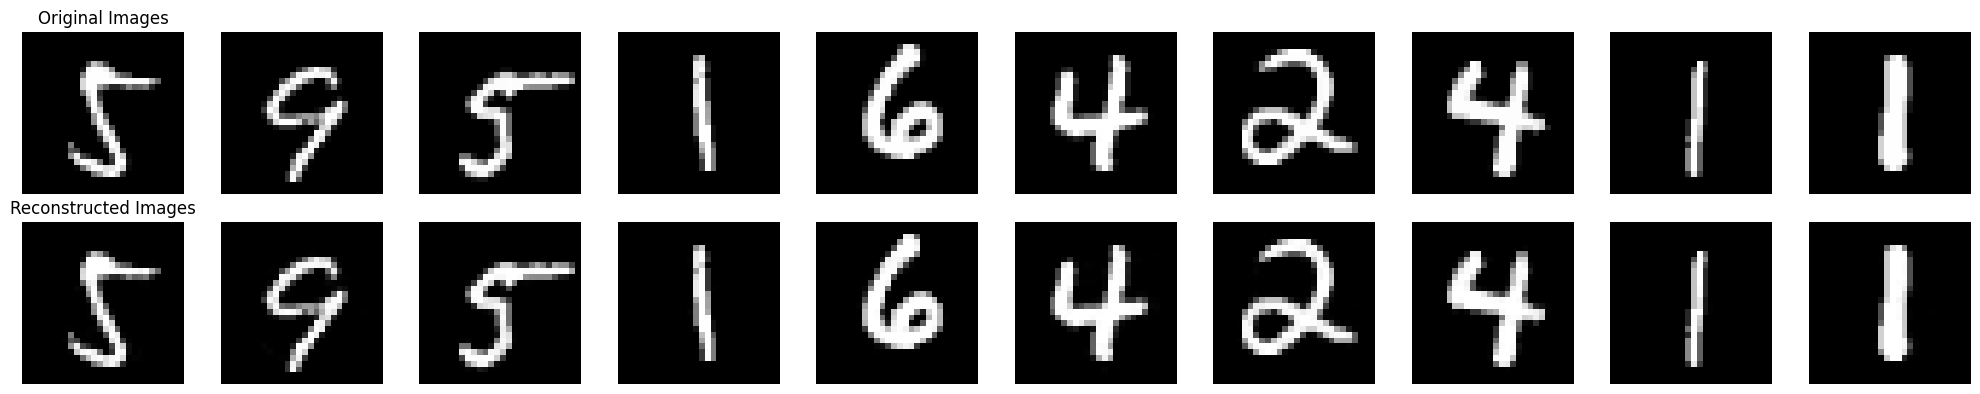

In [23]:
print_imgs(X_test, None, num_images=10, pure_noise=True, model=model)

it seems like the reconstruction is converging to the data manifold, but the hidden representation might not be adequate.

## Unsupervised layerwise pretraining
In the following, we are going to see if performance increases when stacking auto-encoder, i.e. using a deep-AE.

To do so, we will train each auto-encoder separately, starting from the input data. The auto-encoders following the first one will take as input the previous encoder's representation. Thus at each training step the decoder will be discarded, up until the last layer.

In [24]:
def create_autoencoder(input_dim, encoding_dim):
    input_layer = K.Input(shape=(input_dim,))
    encoder_layer = K.layers.Dense(encoding_dim, activation='relu')(input_layer)
    decoder_layer = K.layers.Dense(input_dim, activation='sigmoid')
    decoder_output = decoder_layer(encoder_layer)
    
    autoencoder = K.Model(input_layer, decoder_output)
    encoder = K.Model(input_layer, encoder_layer)
    
    decoder_input = K.Input(shape=(encoding_dim,))
    decoder_output = decoder_layer(decoder_input)
    decoder = K.Model(decoder_input, decoder_output)
    
    autoencoder.compile(
        optimizer='adam',
        loss='mean_squared_error'
    )
    
    return autoencoder, encoder, decoder

def layerwise_pretraining(data, layers, noise_level=0.5, epochs=20):
    encoders = []
    decoders = []
    inputs = data
    
    for i, (input_dim, encoding_dim) in enumerate(zip(layers[:-1], layers[1:])):
        early_stopping = K.callbacks.EarlyStopping(
            monitor='val_loss',
            min_delta=0.0001,
            patience=5,
            verbose=1,
            restore_best_weights=True)
        print(f"Training layer {i+1}/{len(layers)-1}")
        print(f'creating ae #{i} with input_dim:{input_dim}, encoding_dim:{encoding_dim}')

        noisy_inputs = noising_process(inputs, noise_level)
        
        autoencoder, encoder, decoder = create_autoencoder(input_dim, encoding_dim)
        autoencoder.summary()
        
        autoencoder.fit(
            noisy_inputs,
            inputs,
            epochs=epochs,
            batch_size=128,
            shuffle=True,
            validation_split=0.2,
            callbacks=[early_stopping]
        )
    
        inputs = encoder(noisy_inputs)
        encoders.append(encoder)
        decoders.append(decoder)
        
    return encoders, decoders

In [25]:
X_train_reshaped = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_test_reshaped = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

In [26]:
layer_sizes = [784, 1024, 1024]
encoders, decoders = layerwise_pretraining(X_train_reshaped, layer_sizes, epochs=50)

Training layer 1/2
creating ae #0 with input_dim:784, encoding_dim:1024


Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │       803,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 784)            │       803,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,607,440 (6.13 MB)

 Trainable params: 1,607,440 (6.13 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
 67/375 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0939

W0000 00:00:1715522636.779106     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


352/375 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0562

W0000 00:00:1715522638.077619     115 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0550 - val_loss: 0.0227
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0201 - val_loss: 0.0167
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0156 - val_loss: 0.0154
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0143 - val_loss: 0.0147
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0134 - val_loss: 0.0142
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0128 - val_loss: 0.0139
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0122 - val_loss: 0.0137
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0117 - val_loss: 0.0135
Epoch 9/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0113 - val_loss: 0.0134
Epoch 10/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0109 - val_loss: 0.0132
Epoch 11/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0105 - val_loss: 0.0132
Epoch 12/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1024)           │     1,049,600 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,099,200 (8.01 MB)

 Trainable params: 2,099,200 (8.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.2237 - val_loss: 0.1558
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1535 - val_loss: 0.1476
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1470 - val_loss: 0.1446
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1444 - val_loss: 0.1435
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1434 - val_loss: 0.1424
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1416 - val_loss: 0.1418
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1412 - val_loss: 0.1416
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1405 - val_loss: 0.1413
Epoch 9/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1401 - val_loss: 0.1412
Epoch 10/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1399 - val_loss: 0.1411
Epoch 11/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.1397 - val_loss: 0.1410
Epoch 12/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

In [27]:
stacked_ae = K.Sequential()
stacked_ae.add(K.Input((28, 28)))
stacked_ae.add(K.layers.Flatten())
for encoder in encoders:
    stacked_ae.add(encoder.layers[1])
    
for decoder in decoders[::-1]:
    stacked_ae.add(decoder.layers[1])
    
stacked_ae.add(K.layers.Reshape((28, 28)))
    
stacked_ae.compile(
    optimizer='adam',
    loss='mean_squared_error'
)
stacked_ae.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_3 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │       803,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 784)            │       803,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_3 (Reshape)             │ (None, 28, 28)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,706,640 (14.14 MB)

 Trainable params: 3,706,640 (14.14 MB)

 Non-trainable params: 0 (0.00 B)

124/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

W0000 00:00:1715522674.700086     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


W0000 00:00:1715522675.268386     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


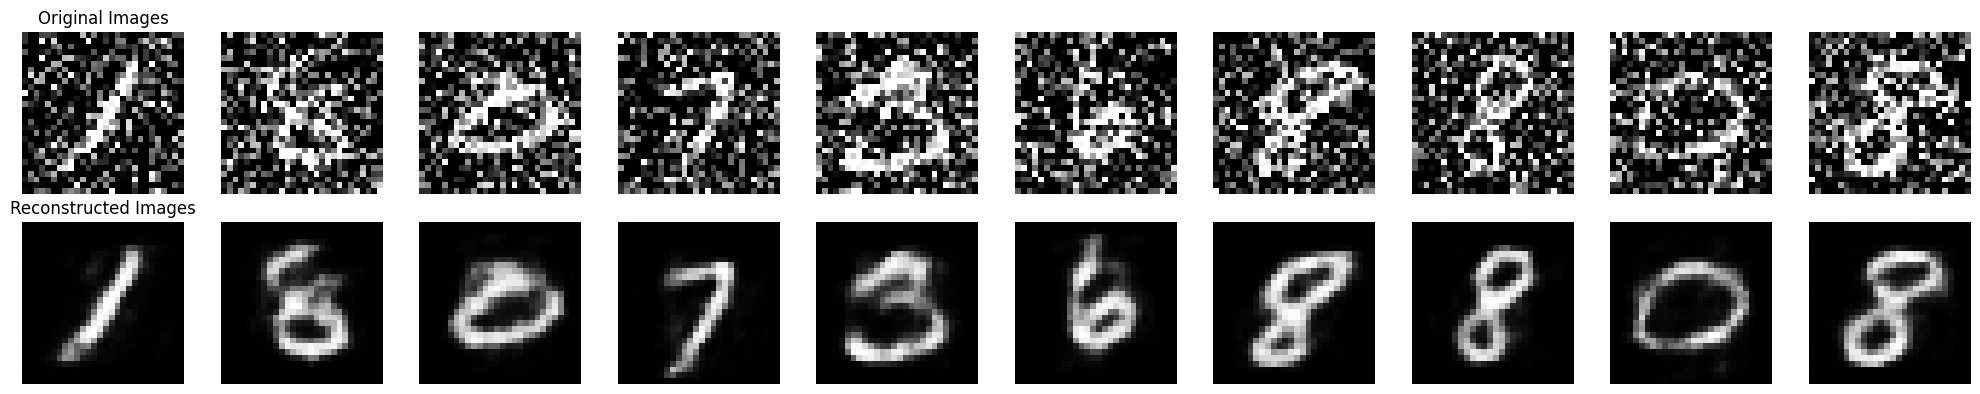

In [28]:
noised_data = noising_process(X_test, 0.5)

predictions = stacked_ae.predict(noised_data)
print_imgs(noised_data, predictions)

In [29]:
noisy_test = noising_process(X_test, 0.5)
predictions = stacked_ae.predict(noisy_test)
mse = K.losses.MeanSquaredError()
reconstruction_error = mse(X_test, predictions).numpy()

print(f'Reconstruction error post pre-training: {reconstruction_error}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Reconstruction error post pre-training: 0.017798395827412605


In [30]:
early_stopping = K.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=5,
    verbose=1,
    restore_best_weights=True)

stacked_ae.fit(
    noising_process(X_train, 0.5),
    X_train,
    epochs=50,
    batch_size=128,
    shuffle=True,
    validation_split=0.2,
    callbacks=[early_stopping]
)

Epoch 1/50
 42/375 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0174

W0000 00:00:1715522681.769008     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


364/375 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0155

W0000 00:00:1715522683.516939     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


375/375 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0155 - val_loss: 0.0140
Epoch 2/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0127 - val_loss: 0.0134
Epoch 3/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0116 - val_loss: 0.0134
Epoch 4/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0106 - val_loss: 0.0131
Epoch 5/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0099 - val_loss: 0.0131
Epoch 6/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0092 - val_loss: 0.0130
Epoch 7/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0087 - val_loss: 0.0131
Epoch 8/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0082 - val_loss: 0.0131
Epoch 9/50
375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0077 - val_loss: 0.0132
Epoch 9: early stopping
Restoring model weights from the end of the best epoch: 4.


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


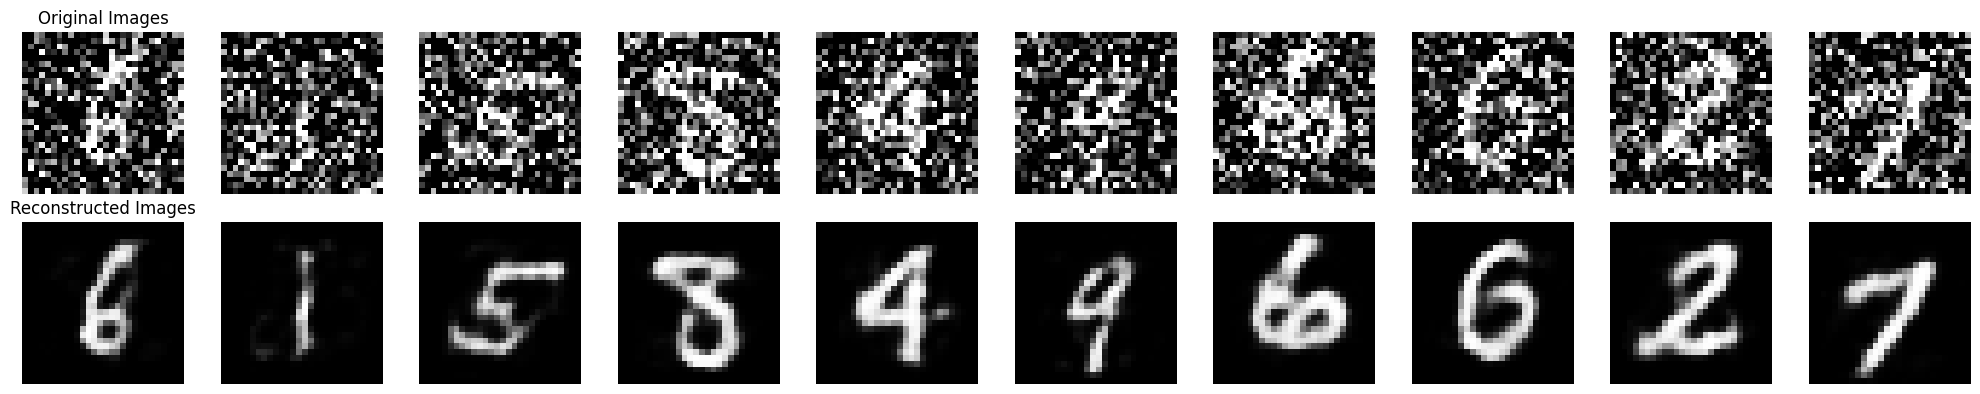

In [31]:
noised_data = noising_process(X_test, 0.6)

predictions = stacked_ae.predict(noised_data).reshape((-1, 28, 28))
print_imgs(noised_data, predictions)

In [32]:
noisy_test = noising_process(X_test, 0.5)
predictions = stacked_ae.predict(noisy_test)
mse = K.losses.MeanSquaredError()
reconstruction_error = mse(X_test, predictions).numpy()

print(f'Reconstruction error post fine-tuning: {reconstruction_error}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Reconstruction error post fine-tuning: 0.012750303372740746


In [33]:
reconstruction = convergence_to_manifold(stacked_ae, X_test[0])

iteration: 0, loss: 53.35853576660156
Not converged. Last iteration 999 w/ loss: 0.7647258639335632 and epsilon: 0.00027829408645629883


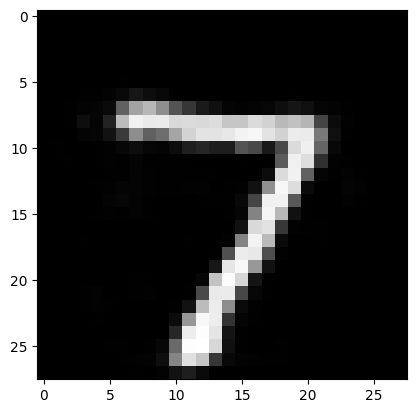

In [34]:
plt.imshow(tf.reshape(reconstruction, (28, 28)), cmap='gray')
plt.show()

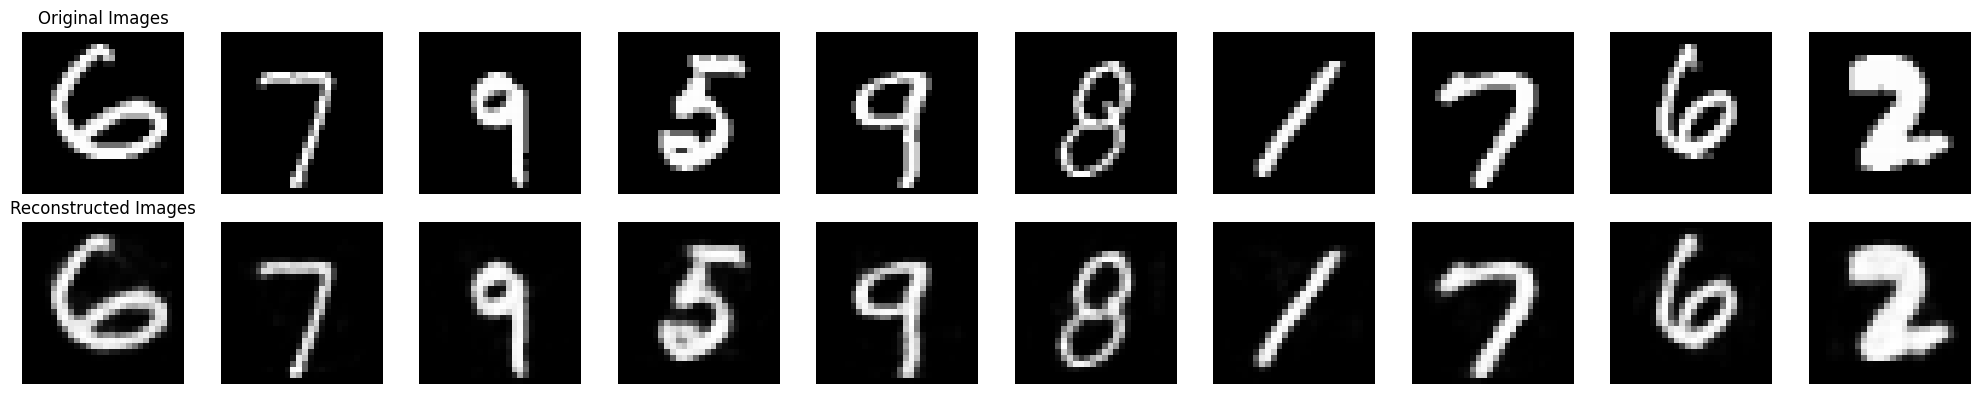

In [35]:
print_imgs(X_test, None, num_images=10, pure_noise=True, model=stacked_ae)

# More hidden layers

In [36]:
inputs = K.Input((28, 28))
x = K.layers.Flatten()(inputs)
x = K.layers.Dense(2048, activation='relu')(x)
x = K.layers.Dropout(0.3)(x)
x = K.layers.Dense(1024, activation='relu')(x)
x = K.layers.Dropout(0.3)(x)
x = K.layers.Dense(784, activation='sigmoid')(x)
outputs = K.layers.Reshape((28, 28)) (x)
model = K.Model(inputs=inputs, outputs=outputs)

model.summary()

model.compile(
    optimizer='adam',
    loss='mean_squared_error'
)

early_stopping = K.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=5,
    verbose=1,
    restore_best_weights=True)

model.fit(
    noising_process(X_train, 0.5),
    X_train,
    epochs=20,
    batch_size=128,
    shuffle=True,
    validation_data=(noising_process(X_test, 0.5), X_test),
    callbacks=[early_stopping]
)

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_8 (InputLayer)      │ (None, 28, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 2048)           │     1,607,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 784)            │       803,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_4 (Reshape)             │ (None, 28, 28)         │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,509,456 (17.20 MB)

 Trainable params: 4,509,456 (17.20 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
 44/469 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.1118

W0000 00:00:1715522869.311563     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0526

W0000 00:00:1715522873.695148     114 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1715522874.263745     113 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


469/469 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 0.0526 - val_loss: 0.0181
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0206 - val_loss: 0.0154
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0180 - val_loss: 0.0144
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0168 - val_loss: 0.0138
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0160 - val_loss: 0.0135
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0154 - val_loss: 0.0133
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0150 - val_loss: 0.0132
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0147 - val_loss: 0.0131
Epoch 9/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0143 - val_loss: 0.0130
Epoch 10/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0141 - val_loss: 0.0128
Epoch 11/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0139 - val_loss: 0.0129
Epoch 12/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 

131/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

W0000 00:00:1715522897.250388     116 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


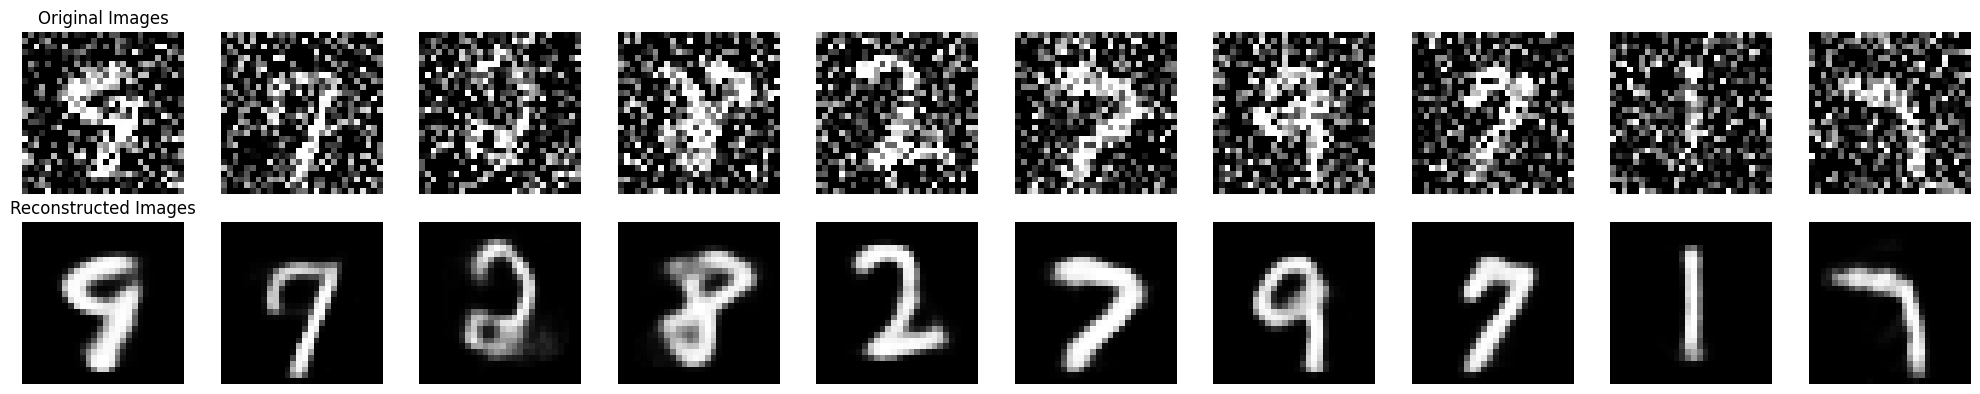

In [37]:
noised_data = noising_process(X_test, 0.5)

predictions = model.predict(noised_data)
print_imgs(noised_data, predictions)

In [38]:
noisy_test = noising_process(X_test, 0.5)
predictions = model.predict(noisy_test)
mse = K.losses.MeanSquaredError()
reconstruction_error = mse(X_test, predictions).numpy()

print(f'Reconstruction error: {reconstruction_error}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Reconstruction error: 0.012909028679132462


In [39]:
reconstruction = convergence_to_manifold(model, X_test[0])

iteration: 0, loss: 60.71723937988281
Not converged. Last iteration 999 w/ loss: 0.27166152000427246 and epsilon: 0.0002097785472869873


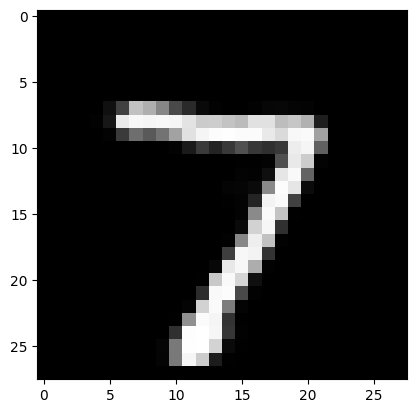

In [40]:
plt.imshow(tf.reshape(reconstruction, (28, 28)), cmap='gray')
plt.show()

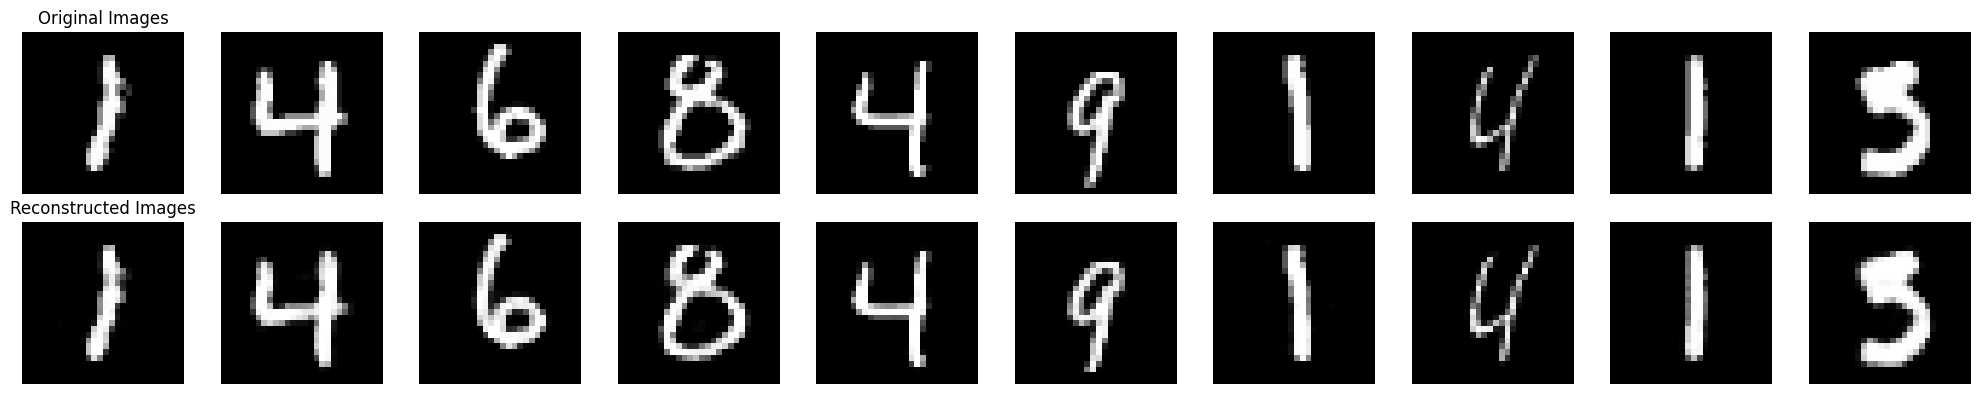

In [41]:
print_imgs(X_test, None, num_images=10, pure_noise=True, model=model)

## Using a U-Shaped CNN as encoder-decoder structure
Since we are dealing with images, we will now see whether using a U-Shaped CNN gives us any conspicuous advantage. We will restrict ourselves to just explore a simple structure of two convolutions/deconvolutions (where we will use maxpooling to downsample and a strided deconvolution to upsample).

In [42]:
conv_inputs = K.Input(shape=((28, 28, 1)))
x_conv = K.layers.Conv2D(16, (3,3), padding='same')(conv_inputs)
x_conv = K.layers.BatchNormalization()(x_conv)
x_conv = K.layers.Activation('relu')(x_conv)
x_conv = K.layers.MaxPooling2D((2,2))(x_conv)
x_conv = K.layers.Conv2D(64, (3,3), padding='same')(x_conv)
x_conv = K.layers.BatchNormalization()(x_conv)
x_conv = K.layers.Activation('relu')(x_conv)
x_conv = K.layers.MaxPooling2D((2,2))(x_conv)

x_conv = K.layers.Conv2DTranspose(64, (3,3), strides=2, padding='same')(x_conv)
x_conv = K.layers.BatchNormalization()(x_conv)
x_conv = K.layers.Activation('relu')(x_conv)
x_conv = K.layers.Conv2DTranspose(16, (3,3), strides=2, padding='same')(x_conv)
x_conv = K.layers.BatchNormalization()(x_conv)
x_conv = K.layers.Activation('relu')(x_conv)
conv_outputs = K.layers.Conv2D(1, (3,3), activation='sigmoid', padding='same')(x_conv)

conv_model = K.Model(inputs=conv_inputs, outputs=conv_outputs)

conv_model.summary()

conv_model.compile(
    optimizer='adam',
    loss='mean_squared_error'
)

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 28, 28, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │         9,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 28, 28, 16)     │         9,232 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 28, 28, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 1)      │           145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,385 (220.25 KB)

 Trainable params: 56,065 (219.00 KB)

 Non-trainable params: 320 (1.25 KB)

In [43]:
early_stopping = K.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=5,
    verbose=1,
    restore_best_weights=True)

conv_model.fit(
    X_train,
    X_train,
    epochs=20,
    batch_size=128,
    shuffle=True,
    validation_data=(X_test, X_test),
    callbacks=[early_stopping]
)

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 15s 17ms/step - loss: 0.0397 - val_loss: 0.0035
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0022 - val_loss: 0.0017
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0011 - val_loss: 9.8168e-04
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 9.9065e-04 - val_loss: 9.5278e-04
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 9.3420e-04 - val_loss: 8.7052e-04
Epoch 9/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 8.7011e-04 - val_loss: 8.5182e-04
Epoch 10/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 8.3699e-04 - val_loss: 7.7759e-04
Epoch 11/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 7.9052e-04 - val_loss: 9.6476e-04
Epoch 

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


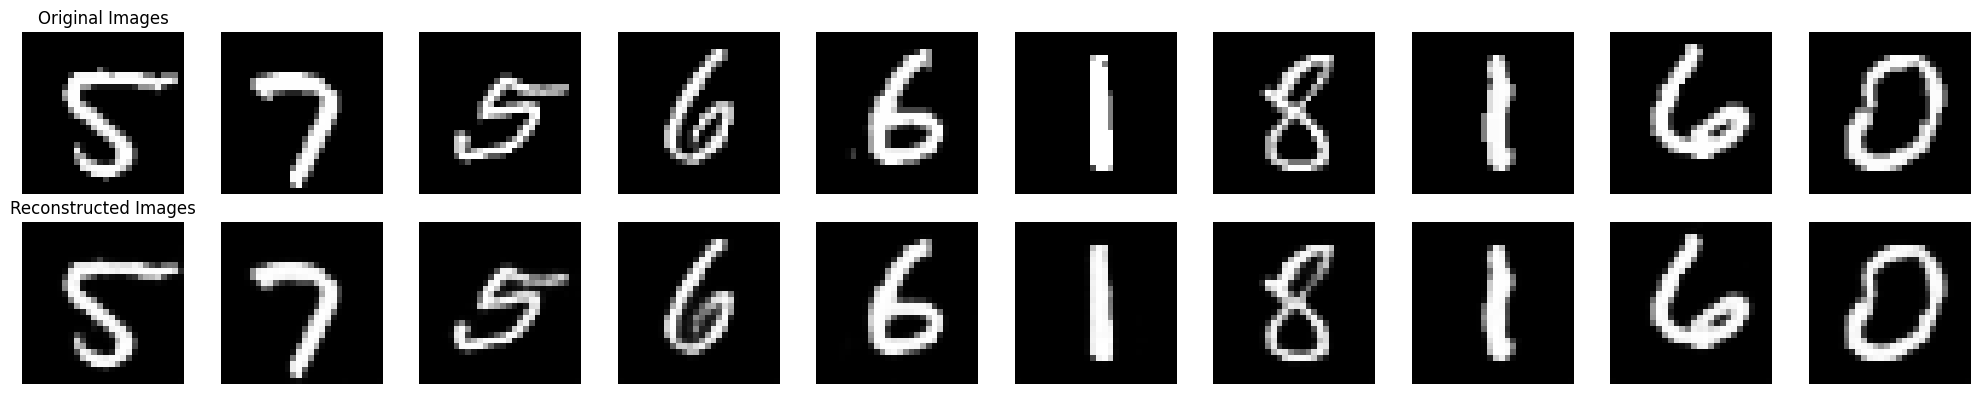

In [44]:
predictions = conv_model.predict(X_test)
print_imgs(X_test, predictions)

In [45]:
conv_inputs = K.Input(shape=((28, 28, 1)))
x_conv = K.layers.Conv2D(16, (3,3), padding='same')(conv_inputs)
x_conv = K.layers.BatchNormalization()(x_conv)
x_conv = K.layers.Activation('relu')(x_conv)
x_conv = K.layers.MaxPooling2D((2,2))(x_conv)
x_conv = K.layers.Conv2D(64, (3,3), padding='same')(x_conv)
x_conv = K.layers.BatchNormalization()(x_conv)
x_conv = K.layers.Activation('relu')(x_conv)
x_conv = K.layers.MaxPooling2D((2,2))(x_conv)

x_conv = K.layers.Conv2DTranspose(64, (3,3), strides=2, padding='same')(x_conv)
x_conv = K.layers.BatchNormalization()(x_conv)
x_conv = K.layers.Activation('relu')(x_conv)
x_conv = K.layers.Conv2DTranspose(16, (3,3), strides=2, padding='same')(x_conv)
x_conv = K.layers.BatchNormalization()(x_conv)
x_conv = K.layers.Activation('relu')(x_conv)
conv_outputs = K.layers.Conv2D(1, (3,3), activation='sigmoid', padding='same')(x_conv)

conv_model = K.Model(inputs=conv_inputs, outputs=conv_outputs)

conv_model.summary()

conv_model.compile(
    optimizer='adam',
    loss='mean_squared_error'
)

early_stopping = K.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.0001,
    patience=5,
    verbose=1,
    restore_best_weights=True)

conv_model.fit(
    noising_process(X_train, 0.5),
    X_train,
    epochs=20,
    batch_size=128,
    shuffle=True,
    validation_data=(noising_process(X_test, 0.5), X_test),
    callbacks=[early_stopping]
)

Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 16)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 28, 28, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 28, 28, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 64)     │         9,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 14, 14, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 28, 28, 16)     │         9,232 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 28, 28, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 28, 28, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 1)      │           145 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,385 (220.25 KB)

 Trainable params: 56,065 (219.00 KB)

 Non-trainable params: 320 (1.25 KB)

Epoch 1/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 0.0528 - val_loss: 0.0170
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0130 - val_loss: 0.0120
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0120 - val_loss: 0.0116
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0115 - val_loss: 0.0112
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0112 - val_loss: 0.0111
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0110 - val_loss: 0.0109
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0109 - val_loss: 0.0108
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0108 - val_loss: 0.0106
Epoch 9/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0107 - val_loss: 0.0111
Epoch 10/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0106 - val_loss: 0.0106
Epoch 11/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0106 - val_loss: 0.0106
Epoch 12/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/st

In [46]:
noisy_test = noising_process(X_test, 0.5)
predictions = conv_model.predict(noisy_test)
mse = K.losses.MeanSquaredError()
reconstruction_error = mse(X_test, predictions).numpy()

print(f'Reconstruction error: {reconstruction_error}')

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Reconstruction error: 0.010647352784872055


The model is able to reconstruct the images even when using some intensive noise

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


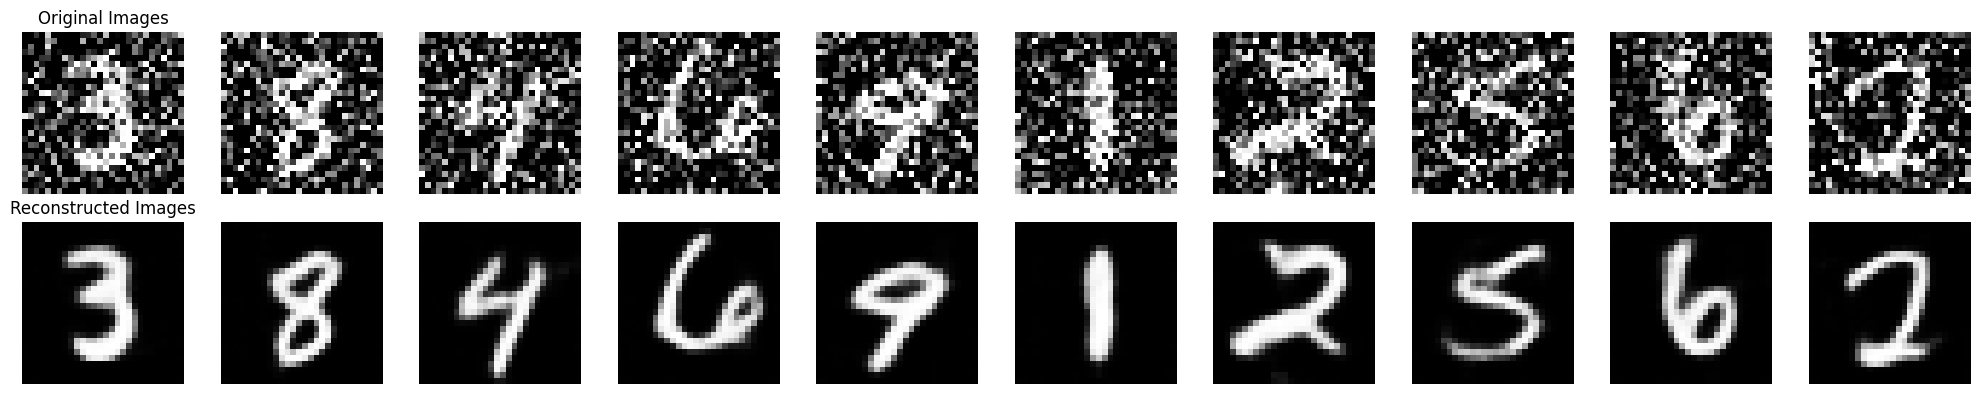

In [47]:
noised_data = noising_process(X_test, 0.5)

predictions = conv_model.predict(noised_data)
print_imgs(noised_data, predictions)

In [48]:
reconstruction = convergence_to_manifold(conv_model, X_test[7])

iteration: 0, loss: 1926.6756591796875
Not converged. Last iteration 999 w/ loss: 1508.6279296875 and epsilon: 0.002685546875


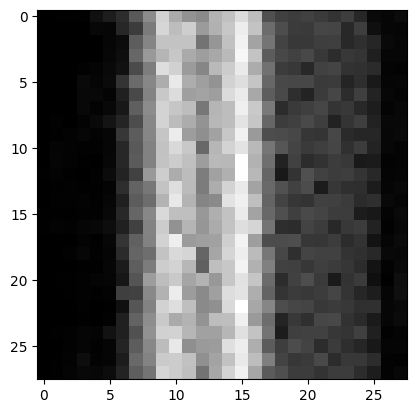

In [49]:
plt.imshow(tf.reshape(reconstruction, (28, 28)), cmap='gray')
plt.show()

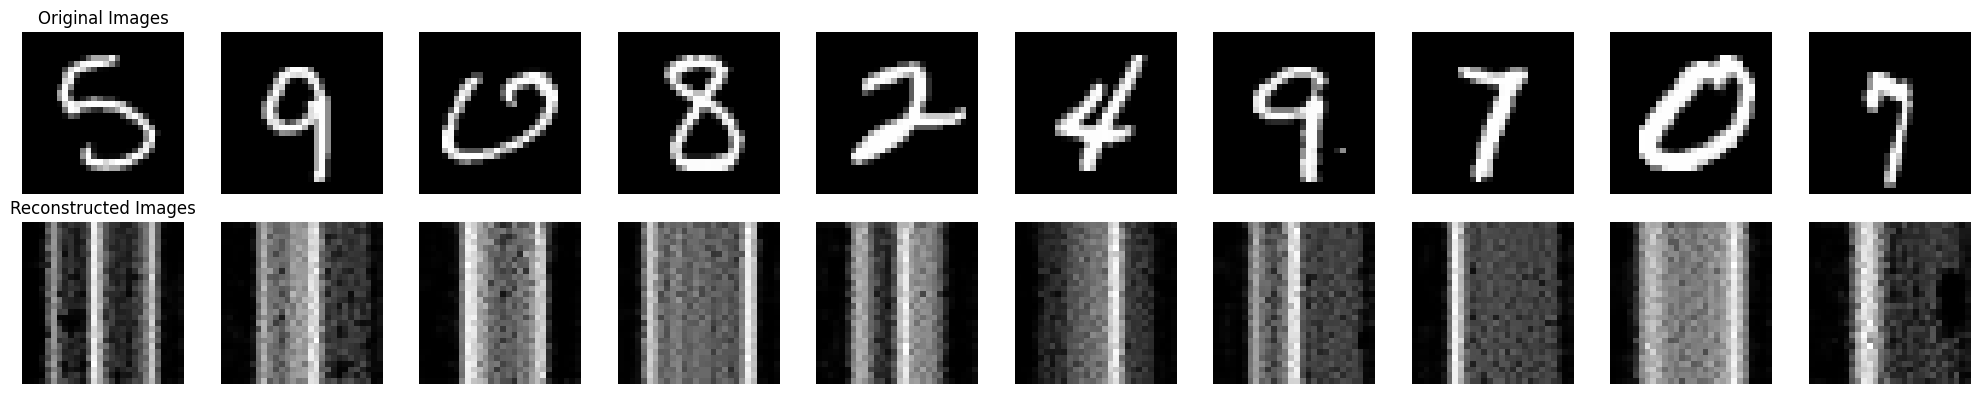

In [50]:
print_imgs(X_test, None, num_images=10, pure_noise=True, model=conv_model)